In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

np.random.seed(42)

In [2]:
# Generate 500 synthetic users

num_users = 500

users = pd.DataFrame({
    "user_id": range(1, num_users + 1),
    "age": np.random.randint(21, 60, num_users),
    "annual_income": np.random.randint(300000, 2000000, num_users),
    "credit_score": np.random.randint(550, 850, num_users),
    "employment_years": np.random.randint(0, 25, num_users)
})

users.head()


,user_id,age,annual_income,credit_score,employment_years
0,1,59,1956940,584,5
1,2,49,1438356,550,6
2,3,35,1501193,845,4
3,4,28,845977,609,10
4,5,41,1699181,816,12


In [3]:
num_transactions = 150000

categories = ["Food", "Shopping", "Bills", "Travel", "Health", "Entertainment"]

transactions = pd.DataFrame({
    "transaction_id": range(1, num_transactions + 1),
    "user_id": np.random.randint(1, num_users + 1, num_transactions),
    "amount": np.round(np.random.normal(3000, 1500, num_transactions), 2),
    "category": np.random.choice(categories, num_transactions),
    "transaction_date": [
        datetime.now() - timedelta(days=random.randint(0, 365))
        for _ in range(num_transactions)
    ]
})

# Remove negative transaction amounts
transactions["amount"] = transactions["amount"].abs()

transactions.head()


,transaction_id,user_id,amount,category,transaction_date
0,1,339,3664.93,Health,2025-09-05 00:36:06.357237
1,2,365,4194.02,Health,2025-10-06 00:36:06.357237
2,3,331,2353.41,Health,2025-06-02 00:36:06.357237
3,4,129,4454.94,Bills,2025-03-02 00:36:06.357237
4,5,344,4344.20,Food,2025-10-22 00:36:06.357237


In [4]:
users.to_csv("../data/users.csv", index=False)
transactions.to_csv("../data/transactions.csv", index=False)

print("Data saved successfully.")


Data saved successfully.


# Phase 3: Financial Metrics & Risk Scoring


In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

users = pd.read_csv("../data/users.csv")
transactions = pd.read_csv("../data/transactions.csv")

transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])

print("Data loaded successfully.")


Data loaded successfully.


In [3]:
user_metrics = (
    transactions
    .groupby("user_id")
    .agg(
        total_spent=("amount", "sum"),
        avg_transaction=("amount", "mean"),
        transaction_count=("amount", "count"),
        spend_std=("amount", "std")
    )
    .reset_index()
)

user_metrics = user_metrics.merge(users, on="user_id")

user_metrics.head()


,user_id,total_spent,avg_transaction,transaction_count,spend_std,age,annual_income,credit_score,employment_years
0,1,852118.09,2979.433881,286,1403.258714,59,1956940,584,5
1,2,890864.30,2949.881788,302,1414.696622,49,1438356,550,6
2,3,898386.37,3045.377525,295,1450.623777,35,1501193,845,4
3,4,948992.80,3051.423794,311,1382.086891,28,845977,609,10
4,5,955417.69,2976.379097,321,1473.008087,41,1699181,816,12


In [4]:
# Income to Expense Ratio
user_metrics["income_expense_ratio"] = (
    user_metrics["annual_income"] / user_metrics["total_spent"]
)

# Spending per transaction ratio (behavioral signal)
user_metrics["spend_per_transaction"] = (
    user_metrics["total_spent"] / user_metrics["transaction_count"]
)

user_metrics.head()


,user_id,total_spent,avg_transaction,transaction_count,spend_std,age,annual_income,credit_score,employment_years,income_expense_ratio,spend_per_transaction
0,1,852118.09,2979.433881,286,1403.258714,59,1956940,584,5,2.296560,2979.433881
1,2,890864.30,2949.881788,302,1414.696622,49,1438356,550,6,1.614562,2949.881788
2,3,898386.37,3045.377525,295,1450.623777,35,1501193,845,4,1.670988,3045.377525
3,4,948992.80,3051.423794,311,1382.086891,28,845977,609,10,0.891447,3051.423794
4,5,955417.69,2976.379097,321,1473.008087,41,1699181,816,12,1.778469,2976.379097


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

features_to_scale = [
    "credit_score",
    "income_expense_ratio",
    "spend_std",
    "employment_years"
]

scaled_values = scaler.fit_transform(user_metrics[features_to_scale])

scaled_df = pd.DataFrame(
    scaled_values,
    columns=[f"{col}_scaled" for col in features_to_scale]
)

user_metrics = pd.concat([user_metrics, scaled_df], axis=1)

user_metrics.head()


,user_id,total_spent,avg_transaction,transaction_count,spend_std,age,annual_income,credit_score,employment_years,income_expense_ratio,spend_per_transaction,credit_score_scaled,income_expense_ratio_scaled,spend_std_scaled,employment_years_scaled
0,1,852118.09,2979.433881,286,1403.258714,59,1956940,584,5,2.296560,2979.433881,0.114094,0.926996,0.393544,0.208333
1,2,890864.30,2949.881788,302,1414.696622,49,1438356,550,6,1.614562,2949.881788,0.000000,0.607015,0.424934,0.250000
2,3,898386.37,3045.377525,295,1450.623777,35,1501193,845,4,1.670988,3045.377525,0.989933,0.633489,0.523531,0.166667
3,4,948992.80,3051.423794,311,1382.086891,28,845977,609,10,0.891447,3051.423794,0.197987,0.267743,0.335441,0.416667
4,5,955417.69,2976.379097,321,1473.008087,41,1699181,816,12,1.778469,2976.379097,0.892617,0.683918,0.584961,0.500000


In [6]:
user_metrics["risk_score"] = (
    0.35 * (1 - user_metrics["credit_score_scaled"]) +
    0.30 * (1 - user_metrics["income_expense_ratio_scaled"]) +
    0.20 * user_metrics["spend_std_scaled"] +
    0.15 * (1 - user_metrics["employment_years_scaled"])
)

# Convert to 0–100 scale
user_metrics["risk_score"] *= 100

user_metrics[["user_id", "risk_score"]].head()


,user_id,risk_score
0,1,52.942694
1,2,66.538210
2,3,34.318282
3,4,65.497009
4,5,32.440088


In [7]:
def categorize_risk(score):
    if score < 35:
        return "Low Risk"
    elif score < 65:
        return "Medium Risk"
    else:
        return "High Risk"

user_metrics["risk_category"] = user_metrics["risk_score"].apply(categorize_risk)

user_metrics[["user_id", "risk_score", "risk_category"]].head()


,user_id,risk_score,risk_category
0,1,52.942694,Medium Risk
1,2,66.538210,High Risk
2,3,34.318282,Low Risk
3,4,65.497009,High Risk
4,5,32.440088,Low Risk


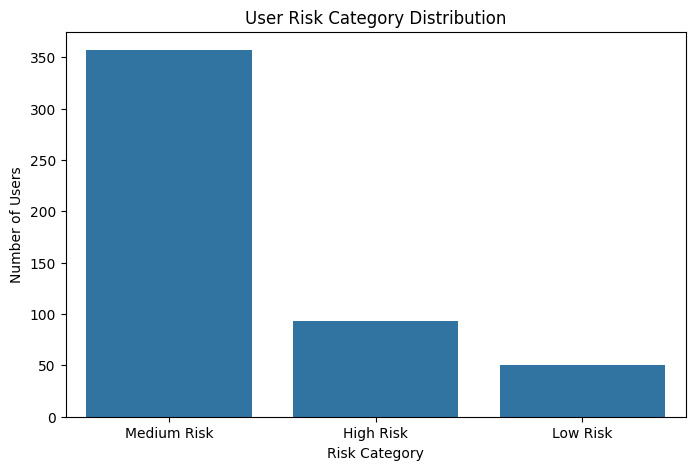

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(data=user_metrics, x="risk_category")
plt.title("User Risk Category Distribution")
plt.xlabel("Risk Category")
plt.ylabel("Number of Users")
plt.show()


In [9]:
user_metrics.to_csv("../data/processed_user_metrics.csv", index=False)

print("Processed dataset saved successfully.")


Processed dataset saved successfully.


### PHASE 4 — Anomaly Detection (Isolation Forest)

In [10]:
# Step 1 — Import Model
from sklearn.ensemble import IsolationForest

In [11]:
# Step 2 — Select Features for Anomaly Detection
anomaly_features = user_metrics[[
    "total_spent",
    "avg_transaction",
    "transaction_count",
    "spend_std"
]]

anomaly_features.head()


,total_spent,avg_transaction,transaction_count,spend_std
0,852118.09,2979.433881,286,1403.258714
1,890864.30,2949.881788,302,1414.696622
2,898386.37,3045.377525,295,1450.623777
3,948992.80,3051.423794,311,1382.086891
4,955417.69,2976.379097,321,1473.008087


In [12]:
# Step 3 — Train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # assume 5% anomalies
    random_state=42
)

user_metrics["anomaly_flag"] = iso_forest.fit_predict(anomaly_features)


In [13]:
user_metrics["anomaly_flag"].value_counts()

anomaly_flag
 1    475
-1     25
Name: count, dtype: int64

In [14]:
# Step 4 — Convert to Clean Label
user_metrics["anomaly_label"] = user_metrics["anomaly_flag"].map({
    1: "Normal",
    -1: "Anomalous"
})

user_metrics[["user_id", "risk_score", "anomaly_label"]].head()


,user_id,risk_score,anomaly_label
0,1,52.942694,Normal
1,2,66.538210,Normal
2,3,34.318282,Normal
3,4,65.497009,Normal
4,5,32.440088,Normal


In [15]:
# Step 5 — Check Anomaly Distribution
user_metrics["anomaly_label"].value_counts()


anomaly_label
Normal       475
Anomalous     25
Name: count, dtype: int64

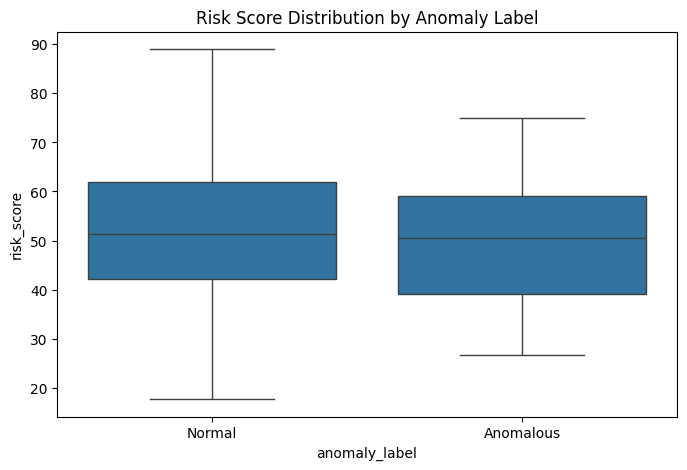

In [16]:
# Step 6 — Visualize Risk vs Anomaly
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data=user_metrics, x="anomaly_label", y="risk_score")
plt.title("Risk Score Distribution by Anomaly Label")
plt.show()


In [17]:
user_metrics.to_csv("../data/processed_user_metrics.csv", index=False)

print("Anomaly detection results saved.")


Anomaly detection results saved.


### 🚀 PHASE 5 — Customer Segmentation (KMeans Clustering)

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

clustering_features = user_metrics[[
    "annual_income",
    "total_spent",
    "transaction_count",
    "spend_std",
    "risk_score"
]]

clustering_features.head()


,annual_income,total_spent,transaction_count,spend_std,risk_score
0,1956940,852118.09,286,1403.258714,52.942694
1,1438356,890864.30,302,1414.696622,66.538210
2,1501193,898386.37,295,1450.623777,34.318282
3,845977,948992.80,311,1382.086891,65.497009
4,1699181,955417.69,321,1473.008087,32.440088


In [19]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)


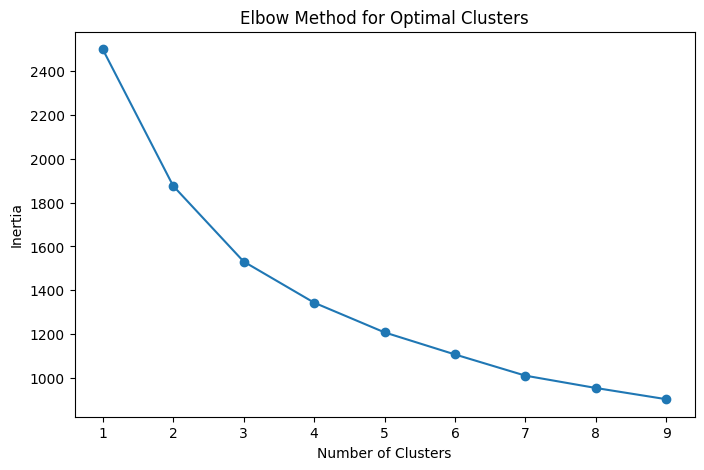

In [20]:
inertia = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, 10), inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [21]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
user_metrics["cluster"] = kmeans.fit_predict(scaled_features)

user_metrics["cluster"].value_counts()


cluster
1    181
0    166
2    153
Name: count, dtype: int64

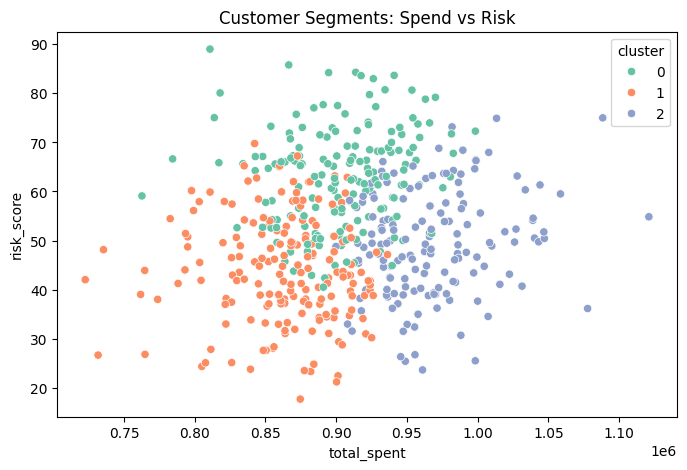

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=user_metrics,
    x="total_spent",
    y="risk_score",
    hue="cluster",
    palette="Set2"
)
plt.title("Customer Segments: Spend vs Risk")
plt.show()


In [23]:
user_metrics.groupby("cluster")[[
    "annual_income",
    "total_spent",
    "risk_score"
]].mean()


,annual_income,total_spent,risk_score
cluster,,,
0,7.304251e+05,902822.801988,63.073480
1,1.410742e+06,862777.053646,43.891805
2,1.286286e+06,968354.105359,49.465613
